## CoTrans-Pilot: Colloquial MT for Indian Languages fine-tuned on Spoken Dialouge

### Linguistic Analysis for Colloquiality on IndicVoices

### Defining Colloquiality
> **Colloquiality** is the natural variability of spoken language, characterized by **disfluencies**, regional **accents**, **dialects**, **code-mixing**, **informality**, and **linguistic entropy**

### Chosen Languages for this experiment
- Hindi (hi)
- Telugu (te)
- Malayalam (ml)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jiwer
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer

#### Dataset Loading
- Merge all languages datasets as one single utterances.csv
- Load from utterances.csv

In [4]:
# Merge all languages datasets (analysis/hindi.csv, analysis/telugu.csv, analysis/malayalam.csv)as one single utterances.csv

def merge_datasets():
    # Load datasets
    hindi_df = pd.read_csv('analysis/hindi.csv')
    telugu_df = pd.read_csv('analysis/telugu.csv')
    malayalam_df = pd.read_csv('analysis/malayalam.csv')

    # Concatenate dataframes
    merged_df = pd.concat([hindi_df, telugu_df, malayalam_df], ignore_index=True)

    # Save to analysis/utterances.csv
    merged_df.to_csv('analysis/utterances.csv', index=False)
    print("Datasets merged successfully into analysis/utterances.csv")  

merge_datasets()

Datasets merged successfully into analysis/utterances.csv


In [40]:
# unique speakers count per each language

def get_unique_speakers_per_language():
    # Load merged dataset
    df = pd.read_csv('analysis/utterances.csv')

    # Get unique speakers count per language
    unique_speakers_per_language = df.groupby('lang')['speaker_id'].nunique()
    
    print("Unique speakers count per language:")
    print(unique_speakers_per_language)
    
    return unique_speakers_per_language

unique_speakers_per_language = get_unique_speakers_per_language()

Unique speakers count per language:
lang
hi    2227
ml    1233
te    1273
Name: speaker_id, dtype: int64


In [5]:
# Generate IDs for all utterances in the merged dataset

def generate_ids():
    # Load merged dataset
    merged_df = pd.read_csv('analysis/utterances.csv')

    # Generate IDs
    merged_df['id'] = range(1, len(merged_df) + 1)

    # Update the utterances.csv with IDs
    merged_df.to_csv('analysis/utterances.csv', index=False)
    print("IDs generated and saved to analysis/utterances.csv")

generate_ids()

IDs generated and saved to analysis/utterances.csv


### Deduplication

In [6]:
# Remove duplicates from the utterances.csv file on 'verbatim' column

def remove_duplicates():
    # Load merged dataset
    merged_df = pd.read_csv('analysis/utterances.csv')

    # Remove duplicates based on 'verbatim' column
    deduplicated_df = merged_df.drop_duplicates(subset='verbatim')

    # Save the deduplicated dataset as analysis/utterances_deduplicated.csv
    deduplicated_df.to_csv('analysis/utterances_deduplicated.csv', index=False)
    print("Duplicates removed and saved to analysis/utterances_deduplicated.csv")
    # print the number of duplicates removed
    num_duplicates = len(merged_df) - len(deduplicated_df)
    print(f"Number of duplicates removed: {num_duplicates}")
    print(f"Total unique utterances: {len(deduplicated_df)}")

remove_duplicates()

Duplicates removed and saved to analysis/utterances_deduplicated.csv
Number of duplicates removed: 112347
Total unique utterances: 704098


### Reordering columns

In [7]:
# Reorder and retain specified columns in the deduplicated dataset

def reorder_columns():
    # Load deduplicated dataset
    deduplicated_df = pd.read_csv('analysis/utterances_deduplicated.csv')

    # Specify the desired column order
    columns_order = [
        'id', 'lang', 'verbatim', 'normalized', 'scenario', 'gender', 'age_group', 
        'job_type', 'qualification', 'area', 'district', 'state', 'occupation', 
        'unsanitized_verbatim', 'unsanitized_normalized'
    ]

    # Reorder columns
    reordered_df = deduplicated_df[columns_order]

    # Save the reordered dataset
    reordered_df.to_csv('analysis/utterances_reordered.csv', index=False)
    print("Columns reordered and saved to analysis/utterances_reordered.csv")

reorder_columns()

Columns reordered and saved to analysis/utterances_reordered.csv


### Utterances Distribution

Distribution data saved as analysis/stats/utterances_distribution.csv
Distribution plot saved as analysis/plots/utterances_distribution.png


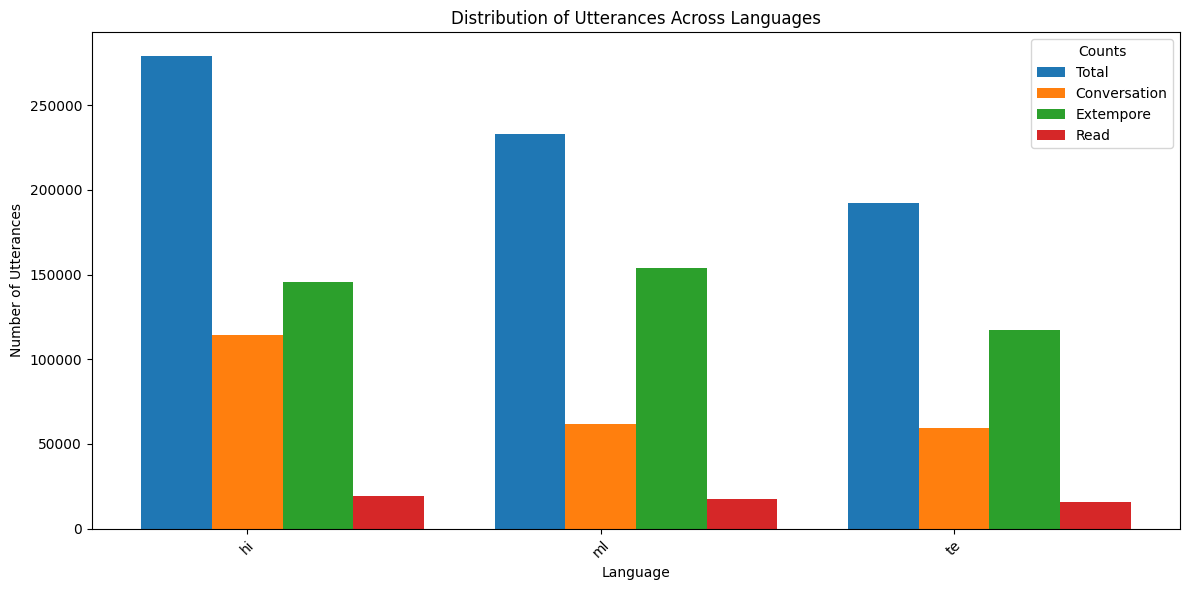

In [35]:
# Plot the combined distribution of utterances across languages with total and scenario-wise counts
# Also save the results as a CSV file

def plot_distribution():
    # Load the reordered dataset
    reordered_df = pd.read_csv('analysis/utterances_reordered.csv')

    # Calculate total counts for each language
    total_counts = reordered_df.groupby('lang').size().reset_index(name='total_count')

    # Calculate scenario-wise counts for each language
    scenario_counts = reordered_df.groupby(['lang', 'scenario']).size().reset_index(name='scenario_count')

    # Merge total and scenario-wise counts
    merged_counts = scenario_counts.merge(total_counts, on='lang')

    # Pivot the data for plotting
    pivot_data = merged_counts.pivot(index='lang', columns='scenario', values='scenario_count').fillna(0)
    pivot_data['total_count'] = total_counts.set_index('lang')['total_count']

    # Save the pivot data to a CSV file
    pivot_data.to_csv('analysis/stats/utterances_distribution.csv')
    print("Distribution data saved as analysis/stats/utterances_distribution.csv")

    # Plotting
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x = range(len(pivot_data.index))

    # Plot total counts
    plt.bar(x, pivot_data['total_count'], width=bar_width, label='Total')

    # Plot scenario-wise counts
    for i, scenario in enumerate(pivot_data.columns[:-1]):  # Exclude 'total_count'
        plt.bar([pos + bar_width * (i + 1) for pos in x], pivot_data[scenario], width=bar_width, label=scenario)

    plt.xlabel('Language')
    plt.ylabel('Number of Utterances')
    plt.title('Distribution of Utterances Across Languages')
    plt.xticks([pos + bar_width for pos in x], pivot_data.index, rotation=45)
    plt.legend(title='Counts')
    plt.tight_layout()

    # Save the plot
    plt.savefig('analysis/plots/utterances_distribution.png')
    print("Distribution plot saved as analysis/plots/utterances_distribution.png")
    plt.show()

plot_distribution()

### Noise tags and disfluency tags

In [1]:
noise_tags = ["TV", "animal", "baby", "baby_crying", "baby_talking", "barking", "beep", "bell",
    "bird_squawk", "breathing", "buzz", "buzzer", "child", "child_crying", "child_laughing",
    "child_talking", "child_whining", "child_yelling", "children", "children_talking",
    "children_yelling", "chiming", "clanging", "clanking", "click", "clicking", "clink",
    "clinking", "cough", "dishes", "door", "footsteps", "gasp", "groan", "hiss", "hmm",
    "horn", "hum", "inhaling", "laughter", "meow", "motorcycle", "music", "noise",
    "nose_blowing", "Persistent-noise-end", "Persistent-noise-start", "phone_ringing",
    "phone_vibrating", "popping", "pounding", "printer", "rattling", "ringing", "rustling",
    "scratching", "screeching", "sigh", "singing", "siren", "smack", "sneezing", "sniffing",
    "Sniffle", "snorting", "squawking", "squeak", "stammers", "static", "swallowing",
    "talking", "tapping", "throat_clearing", "thumping", "tone", "tones", "trill", "tsk",
    "typewriter", "ugh", "uhh", "uh-huh", "umm", "unintelligible", "wheezing", "whispering",
    "whistling", "yawning", "yelling"]

disfluency_tags = ["cough", "gasp", "groan", "hiss", "hmm", "hum", "inhaling", "laughter", "sigh",
    "sneezing", "sniffing", "Sniffle", "snorting", "stammers", "swallowing", "throat_clearing",
    "tsk", "ugh", "uhh", "uh-huh", "umm", "wheezing", "whispering", "yawning"]

### Code-Mixing Identification

In [5]:
# For each utterance, check `unsanitized_normalized`. Split it by space and check if any english words that are not in `noise_tags`. If yes, label it's type as 'code-mixed' else 'standard'
def label_code_mixed():
    # Load the reordered dataset
    reordered_df = pd.read_csv('analysis/utterances_reordered.csv')

    # Function to label utterances
    def label_utterance(unsanitized_normalized):
        words = unsanitized_normalized.split()
        for word in words:
            if word.startswith('[') and word.endswith(']') and word[1:-1].isalpha() and word[1:-1].lower() not in noise_tags and word[1:-1].lower() not in disfluency_tags:
                return 'code-mixed'
        return 'standard'

    # Apply the labeling function
    reordered_df['type'] = reordered_df['unsanitized_normalized'].apply(label_utterance)

    # Save the updated dataset
    reordered_df.to_csv('analysis/utterances_with_type.csv', index=False)
    print("Utterances labeled and saved to analysis/utterances_with_type.csv")

label_code_mixed()

Utterances labeled and saved to analysis/utterances_with_type.csv


### Code-mixing Distribution

Code-mixed vs Standard distribution data saved as analysis/stats/code_mixed_vs_standard_distribution.csv
Code-mixed vs Standard distribution plot saved as analysis/plots/code_mixed_vs_standard_distribution.png


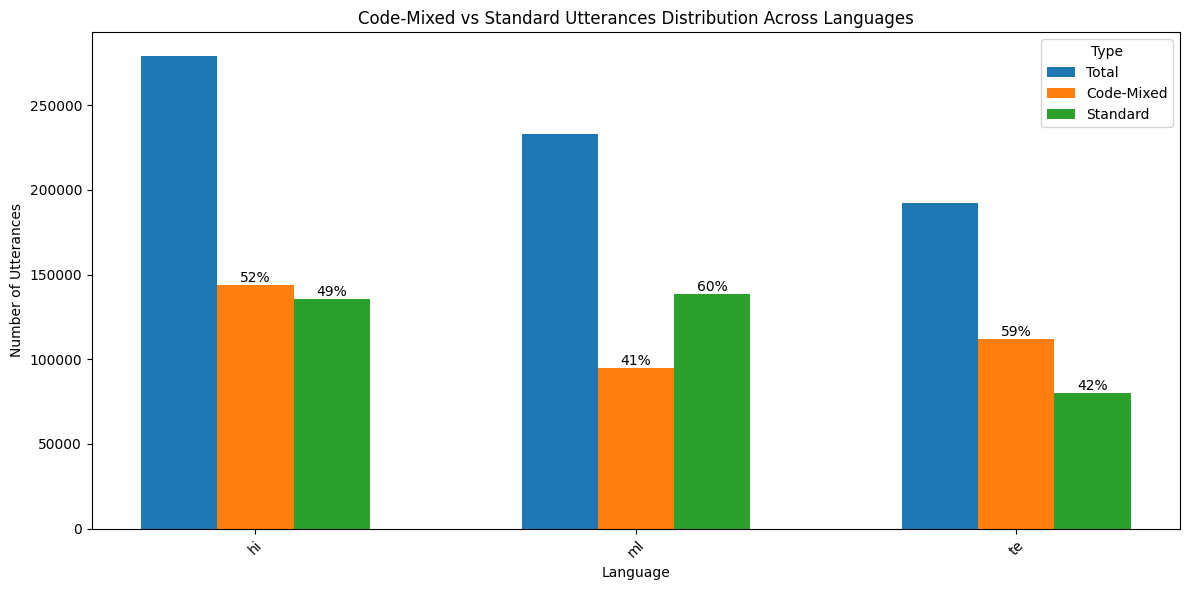

In [ ]:
def plot_code_mixed_vs_standard_distribution():
    # Load the dataset with types
    df = pd.read_csv('analysis/utterances_with_type.csv')

    # Calculate counts for code-mixed and standard utterances for each language
    counts = df.groupby(['lang', 'type']).size().reset_index(name='count')

    # Calculate total counts for each language
    total_counts = df.groupby('lang').size().reset_index(name='total_count')

    # Merge counts with total counts
    pivot_data = counts.pivot(index='lang', columns='type', values='count').fillna(0)
    pivot_data['total'] = total_counts.set_index('lang')['total_count']

    # Calculate percentages and round them up
    pivot_data['code-mixed_percentage'] = np.ceil((pivot_data.get('code-mixed', 0) / pivot_data['total']) * 100)
    pivot_data['standard_percentage'] = np.ceil((pivot_data.get('standard', 0) / pivot_data['total']) * 100)

    # Plotting
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x = range(len(pivot_data.index))

    # Plot total counts
    plt.bar(x, pivot_data['total'], width=bar_width, label='Total')

    # Plot code-mixed counts
    code_mixed_bars = plt.bar([pos + bar_width for pos in x], pivot_data.get('code-mixed', 0), width=bar_width, label='Code-Mixed')

    # Plot standard counts
    standard_bars = plt.bar([pos + bar_width * 2 for pos in x], pivot_data.get('standard', 0), width=bar_width, label='Standard')

    # Add percentage labels on top of code-mixed and standard bars
    for bar, percentage in zip(code_mixed_bars, pivot_data['code-mixed_percentage']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.0f}%', ha='center', va='bottom')
    for bar, percentage in zip(standard_bars, pivot_data['standard_percentage']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.0f}%', ha='center', va='bottom')

    plt.xlabel('Language')
    plt.ylabel('Number of Utterances')
    plt.title('Code-Mixed vs Standard Utterances Distribution Across Languages')
    plt.xticks([pos + bar_width for pos in x], pivot_data.index, rotation=45)
    plt.legend(title='Type')
    plt.tight_layout()

    # Save the results as a CSV file
    pivot_data.to_csv('analysis/stats/code_mixed_vs_standard_distribution.csv')
    print("Code-mixed vs Standard distribution data saved as analysis/stats/code_mixed_vs_standard_distribution.csv")
    
    # Save the plot
    plt.savefig('analysis/plots/code_mixed_vs_standard_distribution.png')
    print("Code-mixed vs Standard distribution plot saved as analysis/plots/code_mixed_vs_standard_distribution.png")
    plt.show()

plot_code_mixed_vs_standard_distribution()

### Disfluency Density
> Frequency of all disfluency tags divided by total words in a given utterance.

$$\rho_d = \frac{d}{N}$$

Where:
- $\rho_d$: Disfluency Density
- $d$: Number of Disfluency Tags in Utterance
- $N$: Total Words in Utterance including disfluencies

In [28]:
# Calculate disfluency density for each utterance and add it as a new column
def calculate_disfluency_density():
    # Load the dataset
    df = pd.read_csv('analysis/utterances_with_type.csv')

    # Function to calculate disfluency density
    def disfluency_density(unsanitized_normalized):
        if not isinstance(unsanitized_normalized, str):
            return 0.0

        # Remove only the brackets but keep the contents inside
        cleaned = unsanitized_normalized.replace("<", "").replace(">", "").replace("[", "").replace("]", "")
        
        # Tokenize
        words = cleaned.strip().split()

        # Count disfluencies
        disfluencies = sum(1 for word in words if word in disfluency_tags)

        return disfluencies / len(words) if words else 0.0

    # Apply the disfluency density function
    df['dd'] = df['unsanitized_normalized'].apply(disfluency_density)

    # Save the updated dataset
    df.to_csv('analysis/utterances_with_disfluency_density.csv', index=False)
    print("✅ Disfluency density calculated and saved to: analysis/utterances_with_disfluency_density.csv")

calculate_disfluency_density()

✅ Disfluency density calculated and saved to: analysis/utterances_with_disfluency_density.csv


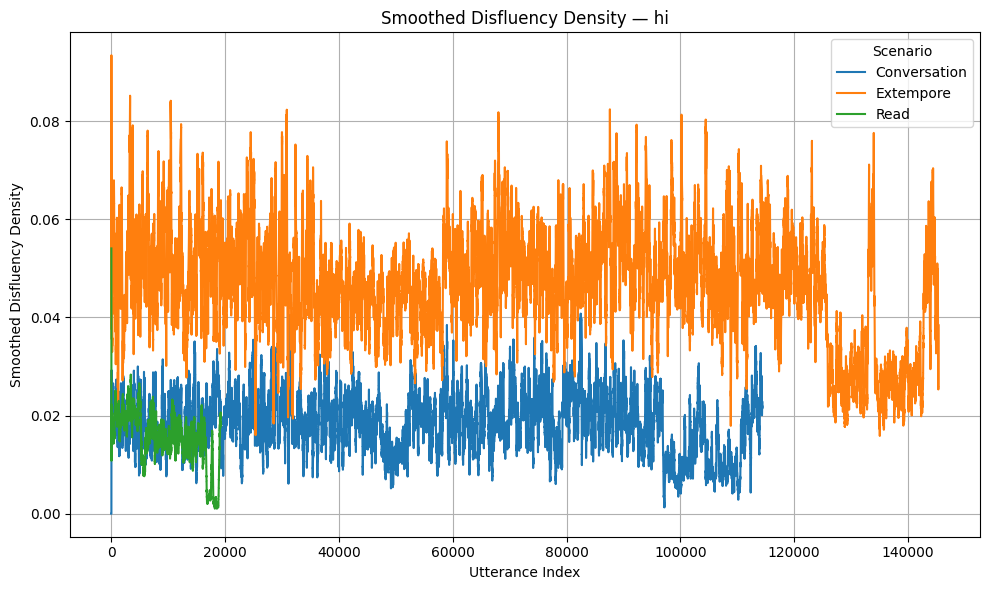

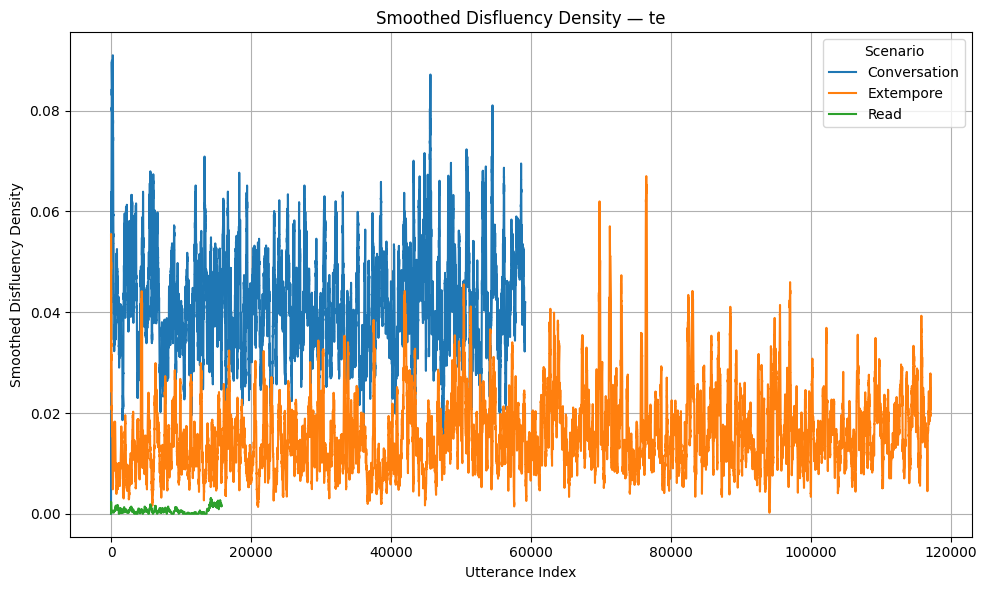

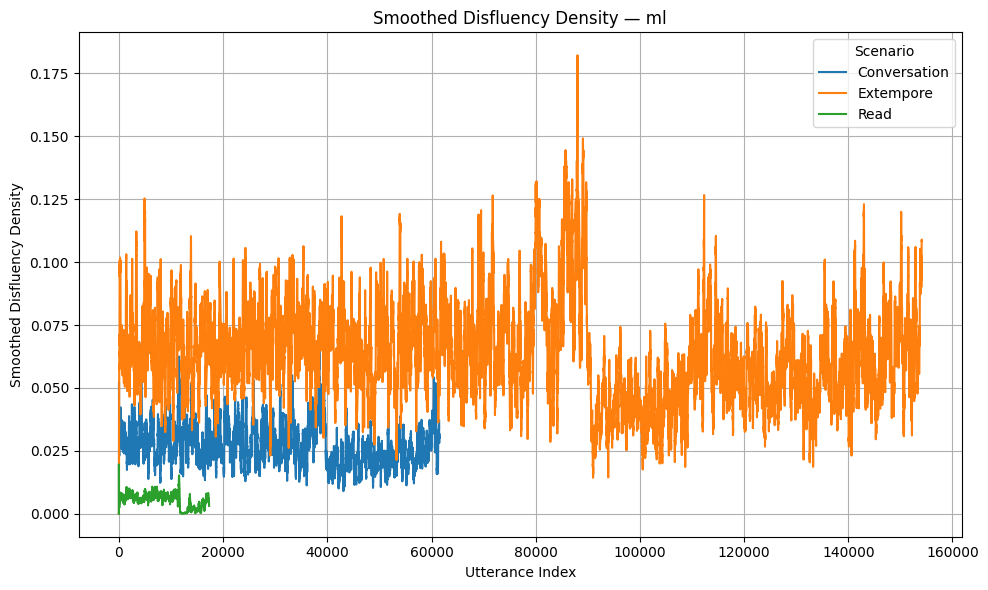

In [ ]:
df = pd.read_csv('analysis/utterances_with_disfluency_density.csv')
df = df.dropna(subset=['lang', 'scenario', 'dd'])

os.makedirs('analysis/plots/smoothed', exist_ok=True)
langs = df['lang'].unique()

for lang in langs:
    lang_df = df[df['lang'] == lang]
    plt.figure(figsize=(10, 6))

    for scenario in sorted(lang_df['scenario'].unique()):
        sub_df = lang_df[lang_df['scenario'] == scenario].reset_index(drop=True)
        sub_df['dd_smooth'] = sub_df['dd'].rolling(window=200, min_periods=1).mean()
        plt.plot(sub_df.index, sub_df['dd_smooth'], label=scenario)

    plt.title(f"Smoothed Disfluency Density — {lang}")
    plt.xlabel("Utterance Index")
    plt.ylabel("Smoothed Disfluency Density")
    plt.legend(title="Scenario")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'analysis/plots/disfluency_curve_smoothed_{lang}.png')
    plt.show()

### Quantifying Accents (WER)

> **Word Error Rate (WER)** can be used to quantify accents or mispronunciations by comparing the `verbatim` and `normalized` transcripts for each utterance. It can be calculated as:

$$\text{WER} = \frac{S + D + I}{N}$$

Where:
- $S$: Number of substitutions (words replaced incorrectly)
- $D$: Number of deletions (words missing in the normalized transcript)
- $I$: Number of insertions (extra words in the normalized transcript)
- $N$: Total number of words in the `verbatim` transcript

A higher WER indicates greater deviation from the original transcript, which may reflect stronger accents or mispronunciations.

In [ ]:
# Load the dataset
df = pd.read_csv('analysis/utterances_with_disfluency_density.csv')
df = df.dropna(subset=['verbatim', 'normalized'])

# Define WER calculation: normalized = reference, verbatim = hypothesis
def calculate_wer(row):
    ref = str(row['normalized'])
    hyp = str(row['verbatim'])
    try:
        return jiwer.wer(ref, hyp)
    except:
        return None

# Apply WER row-wise
df['wer'] = df.apply(calculate_wer, axis=1)

# Save result
os.makedirs("analysis/updated", exist_ok=True)
output_path = "analysis/utterances_with_wer.csv"
df.to_csv(output_path, index=False)
print(f"✅ WER calculated using normalized as reference. Saved to: {output_path}")

✅ WER calculated using normalized as reference. Saved to: analysis/updated/utterances_with_wer.csv


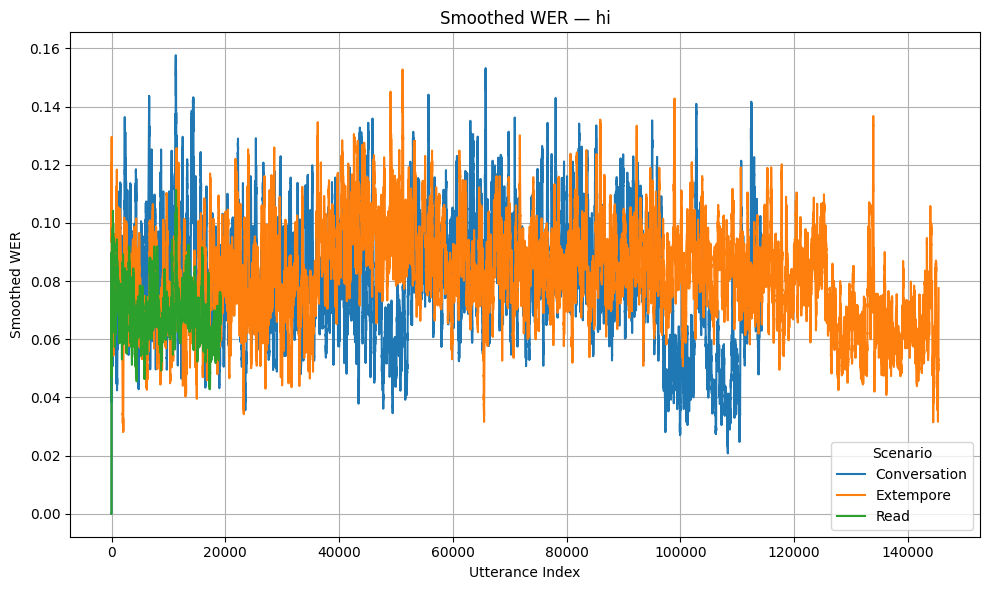

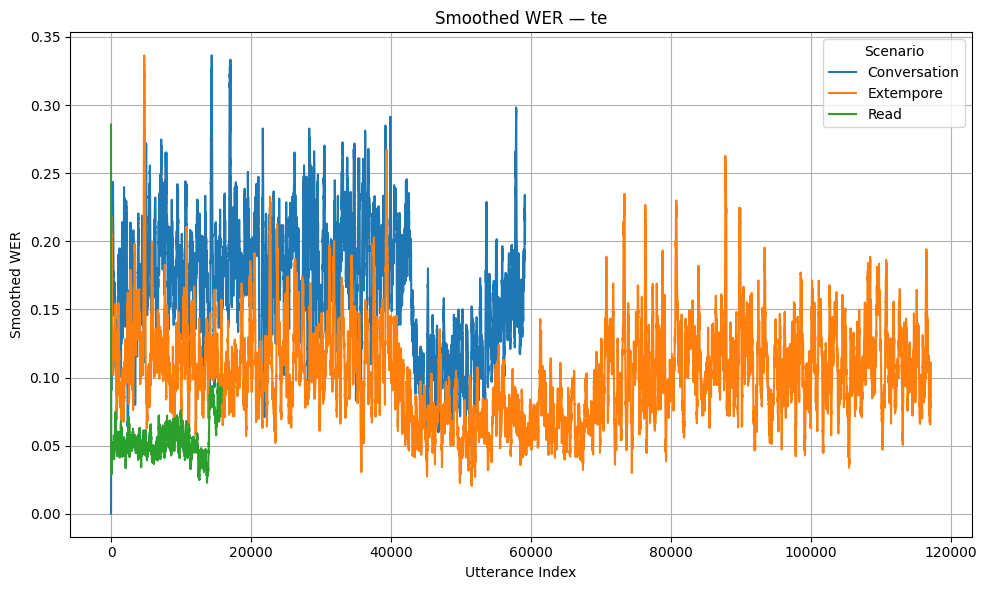

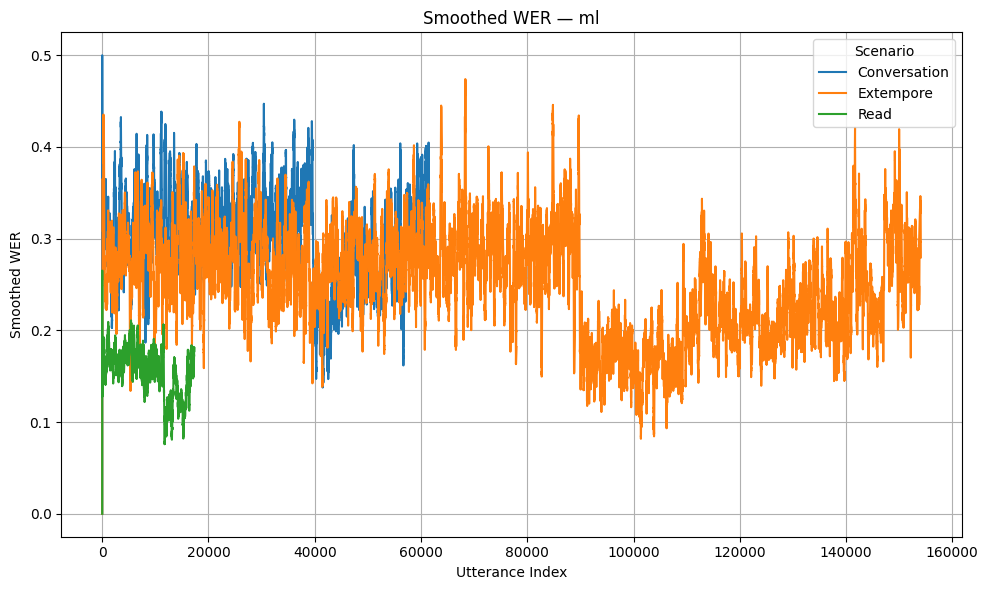

In [5]:
df = pd.read_csv('analysis/utterances_with_wer.csv')
df = df.dropna(subset=['lang', 'scenario', 'wer'])

os.makedirs('analysis/plots', exist_ok=True)
langs = df['lang'].unique()

for lang in langs:
    lang_df = df[df['lang'] == lang]
    plt.figure(figsize=(10, 6))

    for scenario in sorted(lang_df['scenario'].unique()):
        sub_df = lang_df[lang_df['scenario'] == scenario].reset_index(drop=True)
        sub_df['wer_smooth'] = sub_df['wer'].rolling(window=200, min_periods=1).mean()
        plt.plot(sub_df.index, sub_df['wer_smooth'], label=scenario)

    plt.title(f"Smoothed WER — {lang}")
    plt.xlabel("Utterance Index")
    plt.ylabel("Smoothed WER")
    plt.legend(title="Scenario")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'analysis/plots/wer_curve_smoothed_{lang}.png')
    plt.show()

TODO: Use violin plot to present WER vs Exclusive vocabulary across districts

### DVI (Dialectal Variability Index)

> TODO: Use TF-IDF, group utterances by district and consider district groups as documents. 
> And design a DVI which quantifies how many dialectally exclusive words are present in an utterance and how exclusive they are based on their frequency.

In [ ]:
# Load the dataset
df = pd.read_csv("analysis/utterances_with_type.csv")

# Drop rows with missing essential data
df = df.dropna(subset=['district', 'verbatim', 'normalized'])

# Group by district and concatenate utterances
district_docs = df.groupby('district').agg({
    'verbatim': lambda x: ' '.join(x),
    'normalized': lambda x: ' '.join(x)
}).reset_index()

# TF-IDF on 'verbatim'
verbatim_vectorizer = TfidfVectorizer()
verbatim_tfidf = verbatim_vectorizer.fit_transform(district_docs['verbatim'])
verbatim_df = pd.DataFrame(
    verbatim_tfidf.toarray(),
    index=district_docs['district'],
    columns=verbatim_vectorizer.get_feature_names_out()
)

# TF-IDF on 'normalized'
normalized_vectorizer = TfidfVectorizer()
normalized_tfidf = normalized_vectorizer.fit_transform(district_docs['normalized'])
normalized_df = pd.DataFrame(
    normalized_tfidf.toarray(),
    index=district_docs['district'],
    columns=normalized_vectorizer.get_feature_names_out()
)

# Save outputs if needed
verbatim_df.to_csv("analysis/tfidf/tfidf_verbatim_by_district.csv")
normalized_df.to_csv("analysis/tfidf/tfidf_normalized_by_district.csv")

# Optional: print summary
print("TF-IDF matrices created:")
print(f" - Verbatim shape: {verbatim_df.shape}")
print(f" - Normalized shape: {normalized_df.shape}")

TF-IDF matrices created:
 - Verbatim shape: (98, 30051)
 - Normalized shape: (98, 25095)


### Data Splits
> TODO: Split data into three sets
- Test
- Train
- Gold (Ground Truth)

### To Do List

- TODO: Generate english translations to all utterances using GPT
- TODO: Setup IndicTrans2 Fine-Tuning pipeline
- TODO: Fine-Tune IndicTrans2 with English-Indic pairs from the dataset translated by GPT
- TODO: Manually Translate and verify Gold set (100 utterances per language)
- TODO: Translate the same gold set using Google Translate, BhashaVerse, IndicTrans2, Gemini and CoTrans-Pilot
- TODO: Manually score them all on Colloquiality on a scale of 1 to 10
- TODO: And also use LLM-as-a-judge to score them all
- TODO: Evaluate them on BLEU and COMET
- TODO: Design a colloquiality score and evaluate them on that as well
- TODO: Compare the average colloquiality ratings across all models
- TODO: Present the results